In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import tables as tb
import numpy as np
from scipy.signal import find_peaks
from astropy.time import Time, TimeDelta
from tqdm import tqdm
plt.rcParams['figure.figsize'] = [25, 10]

In [2]:
# List of files in directory /data01
os.listdir('/data01')

['output',
 'wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.h5',
 'wf_runId_00240_configId_00000_2022-10-10T08_21_49.133517.h5',
 'wf_runId_00249_configId_00000_2022-10-17T09_45_54.710368.h5',
 'wf_runId_00261_configId_00000_2022-10-24T08_30_50.143648.h5']

### __Test__

* test_0: test base 

  `filePath_dl0=wf_runId_00249_configId_00000_2022-10-17T09_45_54.710368.h5` e `wf_name_original=wf_000146`, `wf_name_new=wf_000147`

* test_1: test con doppio evento non consecutivo  

  `filePath_dl0=wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.h5` e `wf_name_original=wf_000018`, `wf_name_new=``

* test_2: test doppio evento consecutivo 

  `filePath_dl0=wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.h5` e `wf_name_original=wf_000315`, `wf_name_new=``

In [3]:
filePath_dl0 = "/data01/wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.h5"
dl1_path = os.path.join(os.path.dirname(os.getcwd()), 'dl1')
output_dl1_path = os.path.join(dl1_path, 'output_dl1')
filePath_dl1 = os.path.join(output_dl1_path, os.path.basename(filePath_dl0).replace('.h5', '.dl1.h5')) 
print(filePath_dl0)
print(filePath_dl1)

/data01/wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.h5
/home/usergamma/workspace/dl1/output_dl1/wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.dl1.h5


In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
def get_peak_lists(carray_i, deltav=20, thr_heur=80):
    """
    This function returns the list of peaks found in each waveform.
    ### Args
    * `source`: 
    * `deltav`: Define the width of range around peaks
    * `thr_heur`: threshold below which a peak is discarded, it is set as default to 80 and 
                  ithas been chosen with heuristics on data
    """
    # Extract array
    arr = carray_i[:,-1]
    # Compute moving average
    arrmov = moving_average(arr, 15)
    #
    arr3 = arr[:100]
    mmean1 = arr3.mean()
    mmean2 = mmean1 * 2 * 0.9 
    # Find peaks
    peaks, _ = find_peaks(arrmov, height=mmean2, width=15, distance=25)
    # Clone the peaks
    peaks2 = np.copy(peaks)
    # Filtering the peaks
    for v in peaks2:
        arrcalcMM = arrmov[v] - arrmov[v-deltav:v+deltav]
        #  
        ind = np.where(arrcalcMM[:] > thr_heur)
        # Remove peaks too small or peaks too close to the end of the wf
        if len(ind[0]) == 0 or v > 16000:
        # If  v > 16000:
            peaks = peaks[peaks != v]
    return peaks

[1202 7640]


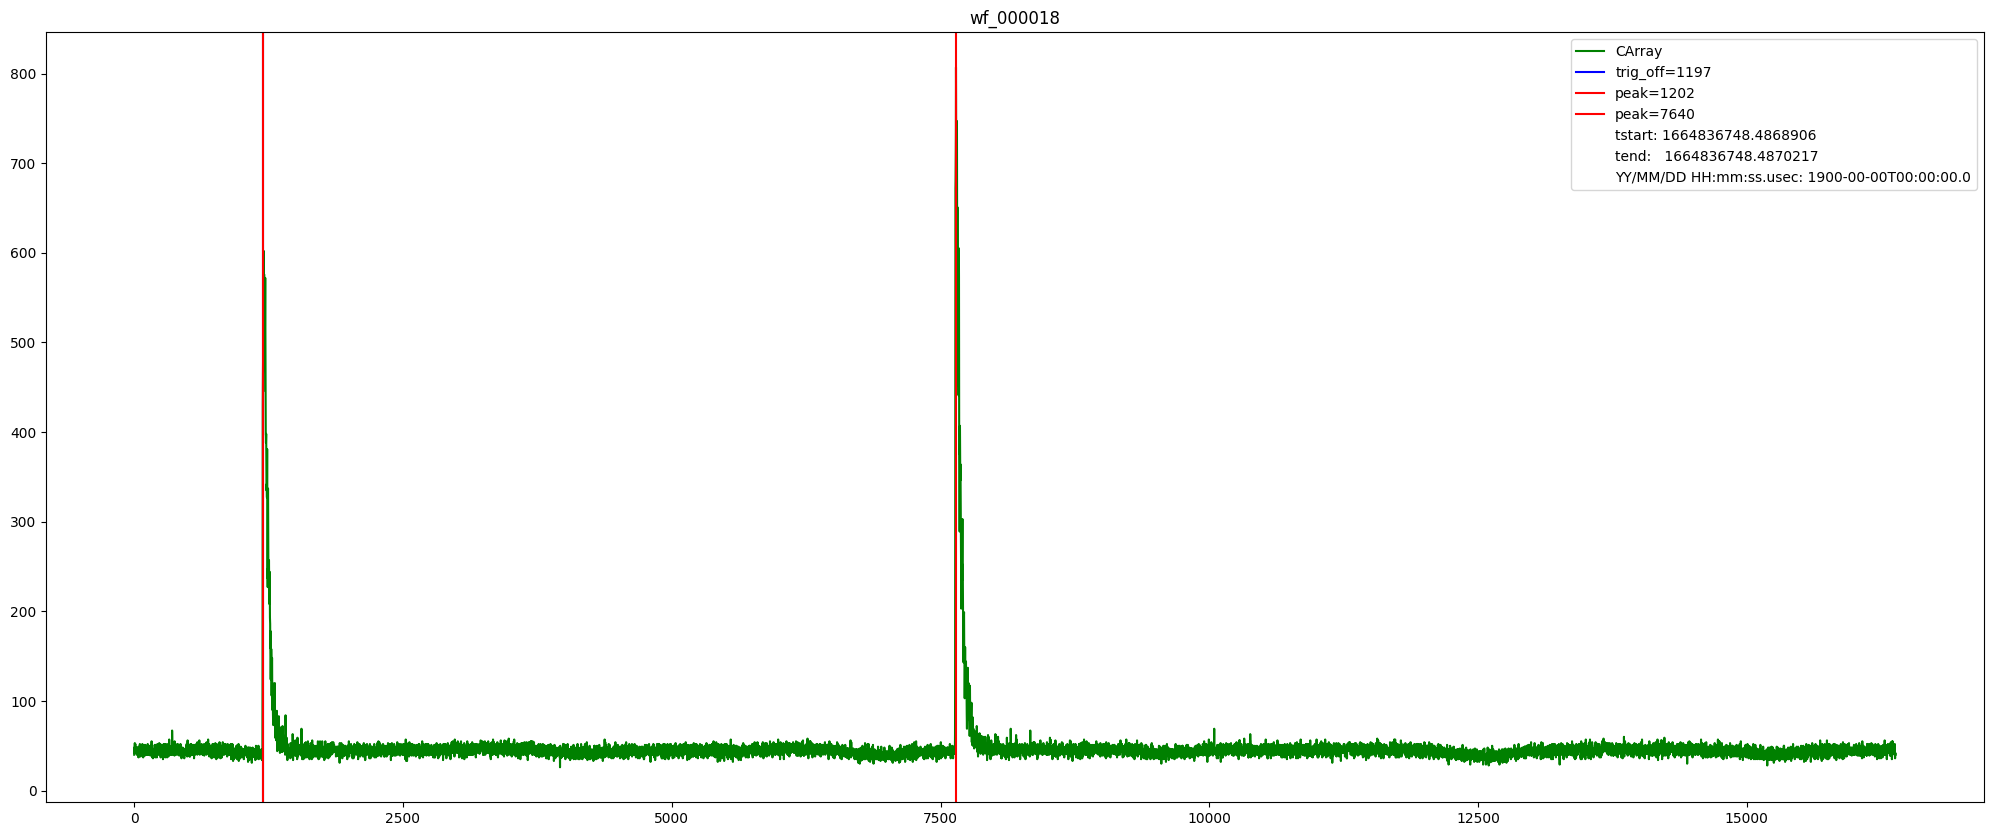

In [6]:
idx0 = f'wf_{18:06d}'
with tb.open_file(filePath_dl0, mode='r') as h5_out:
    group = h5_out.get_node('/','waveforms')
    data = group.__getitem__(idx0)
    # Extract array
    y = data[:,-1]
    lenwf = len(y)
    arr = y
    peaks = get_peak_lists(data)
    print(peaks)
    plt.figure()
    plt.plot(arr, color='g', label="CArray")
    curr_off = data._v_attrs.CurrentOffset + 1
    trig_off = data._v_attrs.TriggerOffset
    tstart_off = (len(data)-curr_off)+trig_off if (curr_off > trig_off) else trig_off-curr_off
    plt.axvline(x=tstart_off, color='b', label=f'trig_off={tstart_off}') 
    for v in peaks:
        plt.axvline(x=v, color='r', label=f'peak={v}') 
    # attrs
    plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
    plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
    plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
                f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
                f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
    plt.title(data._v_name)
    plt.legend()
    plt.show(block=True)

In [11]:
cmd = f"python dl02dl1.py {filePath_dl0} {output_dl1_path}"
!echo $ {cmd}
!{cmd}

$ python dl02dl1.py /data01/wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.h5 /home/usergamma/workspace/dl1/output_dl1
/home/usergamma/workspace/dl1/output_dl1/wf_runId_00115_configId_00000_2022-10-03T22_39_08.295757.dl1.h5
100%|████████████████████████████████████| 10000/10000 [00:50<00:00, 197.32it/s]


### __Test dl0 vs dl1__

In [12]:
idx1 = 'wf_000019'
with tb.open_file(filePath_dl1, mode='r', title='dl1') as h5_out:
    group1 = h5_out.get_node('/','waveforms')
    data = group1.__getitem__(idx1)
    # Extract array
    y = data[:,-1]
    lenwf = len(y)
    arr = y
    peak1 = np.array(get_peak_lists(data))+data._v_attrs.wf_start
    peak = data._v_attrs.peak_pos
    curr_off = data._v_attrs.CurrentOffset + 1
    trig_off = data._v_attrs.TriggerOffset
    trig_off = (len(data)-curr_off)+trig_off if (curr_off > trig_off) else trig_off-curr_off
    plt.figure()
    plt.plot(np.arange(data._v_attrs.wf_start, 
                        data._v_attrs.wf_size + data._v_attrs.wf_start),
            arr, color='g', label="CArray")
    # plt.axvline(x=peak, color='gold', label=f"peak_real={peak}") 
    plt.axvline(x=peak1, color='r', label=f"peak1={peak1}") 
    # plt.axvline(x=trig_off, color='b', label=f"trig_off={trig_off}") 
    plt.title(idx1)
    plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
    plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
    plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
                f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
                f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
    idx0 = data._v_attrs.original_wf
    plt.plot([], label=f"original_wf: {idx0}", linestyle='')
    # data._v_attrs.peak_pos - data._v_attrs.wf_start
    plt.legend()
    plt.show(block=True)

IndexError: wf_000019

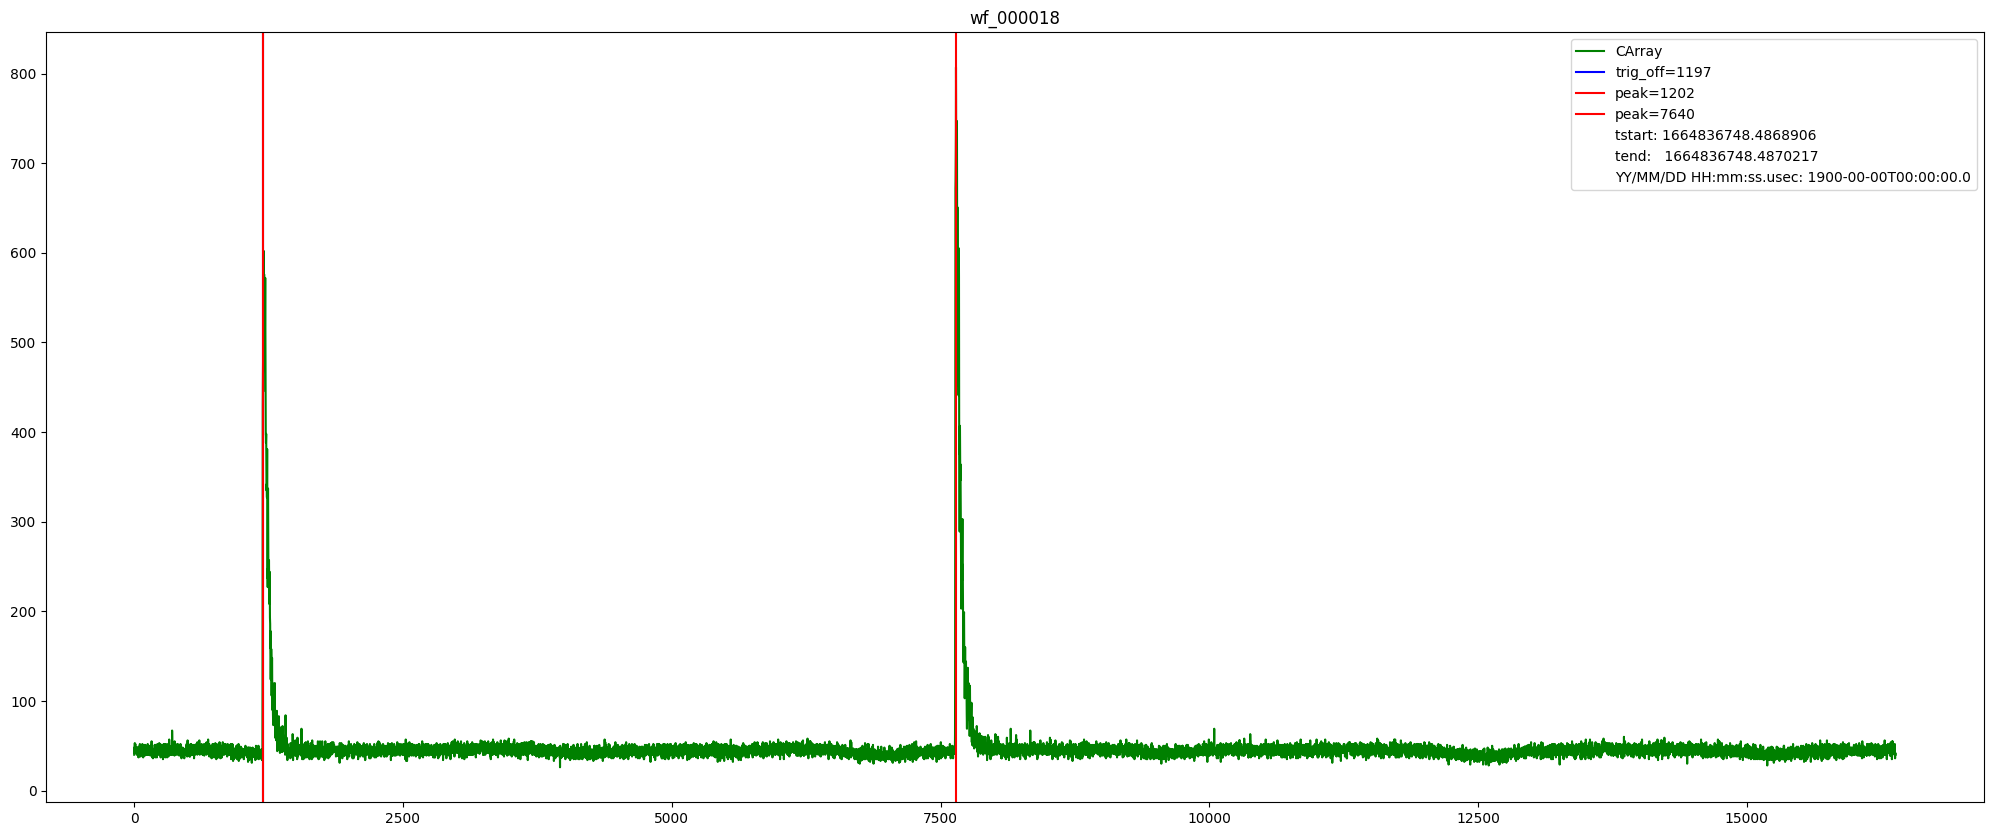

In [8]:
with tb.open_file(filePath_dl0, mode='r') as h5_out:
    group = h5_out.get_node('/','waveforms')
    data = group.__getitem__(idx0)
    # Extract array
    y = data[:,-1]
    lenwf = len(y)
    arr = y
    peaks = get_peak_lists(data)
    plt.figure()
    plt.plot(arr, color='g', label="CArray")
    curr_off = data._v_attrs.CurrentOffset + 1
    trig_off = data._v_attrs.TriggerOffset
    tstart_off = (len(data)-curr_off)+trig_off if (curr_off > trig_off) else trig_off-curr_off
    plt.axvline(x=tstart_off, color='b', label=f'trig_off={tstart_off}') 
    for v in peaks:
        plt.axvline(x=v, color='r', label=f'peak={v}') 
    # attrs
    plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
    plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
    plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
                f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
                f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
    plt.title(data._v_name)
    plt.legend()
    plt.show(block=True)

### __Search multiple peaks__

In [24]:
list_miltiple_events = []
with tb.open_file(filePath_dl0, mode='r') as h5_out:
    group = h5_out.get_node('/','waveforms')
    n_wf = group._g_getnchildren()
    for i in tqdm(range(n_wf)):
        data = group.__getitem__(f'wf_{i:06d}')
        # Extract array
        y = data[:,-1]
        lenwf = len(y)
        arr = y
        peaks = get_peak_lists(data)
        if len(peaks) > 1:
            for v, v1 in zip(peaks, peaks[1:]):
                if v1 - v < 1000:
                    list_miltiple_events.append(data._v_name)
list_miltiple_events

100%|██████████| 10000/10000 [00:49<00:00, 201.86it/s]


['wf_000315',
 'wf_000673',
 'wf_001069',
 'wf_001913',
 'wf_002723',
 'wf_006351',
 'wf_006683',
 'wf_006775',
 'wf_008601',
 'wf_009875']

In [25]:
def plot_dl0(idx_mm):
    with tb.open_file(filePath_dl0, mode='r') as h5_out:
        group = h5_out.get_node('/','waveforms')
        data = group.__getitem__(idx_mm)
        # Extract array
        y = data[:,-1]
        lenwf = len(y)
        arr = y
        peaks = get_peak_lists(data)
        plt.figure()
        plt.plot(arr, color='orange', label="CArray")
        for v in peaks:
            plt.axvline(x=v, color='r', label=f'peak={v}') 
        # attrs
        plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
        plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
        plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
                    f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
                    f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
        plt.title(data._v_name)
        plt.legend()
        plt.show(block=True)

In [26]:
with tb.open_file(filePath_dl1, mode='r') as h5_out:
    group = h5_out.get_node('/','waveforms')
    n_wf = group._g_getnchildren()
    idx0 = None
    for i in tqdm(range(n_wf)):
        idx1 = f'wf_{i:06d}'
        data = group.__getitem__(idx1)
        if data._v_attrs.original_wf in list_miltiple_events:
            if not idx0 == data._v_attrs.original_wf:
                idx0 = data._v_attrs.original_wf
                plot_dl0(idx0)
            # Extract array
            y = data[:,-1]
            lenwf = len(y)
            arr = y
            peaks1 = np.array(get_peak_lists(data))+data._v_attrs.wf_start
            plt.figure()
            plt.title(idx1)
            plt.plot(np.arange(data._v_attrs.wf_start, 
                                data._v_attrs.wf_size + data._v_attrs.wf_start),
                    arr, color='g', label="CArray")
            peak = data._v_attrs.peak_pos
            plt.axvline(x=peak, color='r', label=f"peak_saved={peak}") 
            for v in peaks1:
                plt.axvline(x=v, color='r', linestyle='--') 
            plt.plot([], label=f"peaks found: {peaks1}", color='r', linestyle='--')
            plt.plot([], label=f"tstart: {data._v_attrs.tstart}", linestyle='')
            plt.plot([], label=f"tend:   {data._v_attrs.tend}", linestyle='')
            # plt.plot([], label=f"YY/MM/DD HH:mm:ss.usec: "
            #             f"{data._v_attrs.Year+1900}-{data._v_attrs.Month:02d}-{data._v_attrs.Day:02d}T"
            #             f"{data._v_attrs.HH:02d}:{data._v_attrs.mm:02d}:{data._v_attrs.ss:02d}.{data._v_attrs.usec}", linestyle='')
            plt.plot([], label=f"original_wf: {idx0}", linestyle='')
            plt.plot([], label=f"isdouble flag: {data._v_attrs.isdouble}", linestyle='')
            plt.axhline(y=data._v_attrs.mmean1, color='purple', label=f"mmean1: {data._v_attrs.mmean1}", linestyle='--') 
            plt.legend()
            plt.show(block=True)

0it [00:00, ?it/s]
